<a href="https://colab.research.google.com/github/lfmartins/introduction-to-computational-mathematics/blob/main/18-text-mining-with-pandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Text Mining in Python

From customer reviews, to doctor's notes, to legal memos, most organizations have unstructured text data. We can use natural language processing (NLP) to understand and interpret this data, adding structure where none existed before. In this interactive workshop, we will learn about text mining in the Python programming language. We will clean the text data with preprocessing techniques, use regular expressions for pattern matching, add structure to the data with parts-of-speech tagging and entity recognition, and understand the emotional content of text using sentiment analysis.



## Load Data
Grab the data from Blackboard and load it into Files:

---


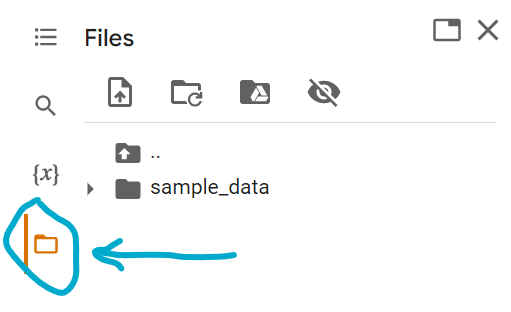

To simplify this tutorial, I've added a few helper functions to make it easier for us to access the data. If you are experienced with Pandas, you can go in and make your own changes but otherwise, please run these helper functions (ctrl-Enter to run a single cell or shift-Enter to run a cell and advance to the next):

In [9]:
import pandas as pd

def import_data():
  """
  Import Cleveland public comments from data source. You must
  have the data stored in the Colab Files folder before this
  will work!!!

  returns: pandas DataFrame with public comments
  """
  df = pd.read_csv("/content/cleveland_public_comments.csv")
  return df

def fetch_row(df, row_num):
  """
  Fetch row from DataFrame by row number

  df: Input DataFrame
  row_num: number of row to fetch

  returns: dictionary with data from a row
  """
  row = df.iloc[row_num]
  return dict(row)

def print_row(row_dict):
  """
  Print data from the row dictionary

  row_dict: dictionary of row data
  """
  print("----------------")
  print("name:  ", row_dict['name'])
  print("date:  ", row_dict['date'])
  print("title: ", row_dict['title'])
  print("content:\n", row_dict['content'])
  print("----------------")


Start by importing the data into a Pandas DataFrame:

In [10]:
data = import_data()

Now we can fetch the data by row number and get a dictionary with all the information for that row. There are four columns in this dataset: name, date, title, and content. What does the first comment look like?

In [11]:
row_0 = fetch_row(data, 0)
print_row(row_0)

----------------
name:   Andrea Hamre
date:   Aug 5, 2022
title:  Ordinance to Release Police Body Cam Footage within 7 Days after Use of Force
content:
 
          Hello,

I'm writing to share my strong support for requiring the release of video footage of police officers using deadly force within seven days of the incident. I understand an Ordinance is under consideration by the full City Council, and urge you to adopt this reform. 

Thank you,
Andrea

https://www.ideastream.org/news/cleveland-city-council-may-require-release-of-some-police-body-cam-footage-within-7-days
        
----------------


To access just one value for the row, we can access it using the associated key name:

In [30]:
row_0['title']

'Ordinance to Release Police Body Cam Footage within 7 Days after Use of Force'

## Text Cleaning
There are a lot of built in functions for string manipulation in vanilla Python. In this part, we will cover some of the essential functions for cleaning up your strings. For more on basic text manipulation, see [this example](https://stackabuse.com/common-string-manipulation-in-python/).

### Stripping Extra Space
We often end up with extra spaces around the text we get. Strip extra space characters from the beginning and end 

In [31]:
example_content = row_0['content']
print(example_content)


          Hello,

I'm writing to share my strong support for requiring the release of video footage of police officers using deadly force within seven days of the incident. I understand an Ordinance is under consideration by the full City Council, and urge you to adopt this reform. 

Thank you,
Andrea

https://www.ideastream.org/news/cleveland-city-council-may-require-release-of-some-police-body-cam-footage-within-7-days
        


In [32]:
print(example_content.strip())

Hello,

I'm writing to share my strong support for requiring the release of video footage of police officers using deadly force within seven days of the incident. I understand an Ordinance is under consideration by the full City Council, and urge you to adopt this reform. 

Thank you,
Andrea

https://www.ideastream.org/news/cleveland-city-council-may-require-release-of-some-police-body-cam-footage-within-7-days


### Lower Case
Another way of cleaning data is to make the text consistent by changing it all to lower case:

In [33]:
print(example_content.lower())


          hello,

i'm writing to share my strong support for requiring the release of video footage of police officers using deadly force within seven days of the incident. i understand an ordinance is under consideration by the full city council, and urge you to adopt this reform. 

thank you,
andrea

https://www.ideastream.org/news/cleveland-city-council-may-require-release-of-some-police-body-cam-footage-within-7-days
        


📔 Be careful with this because some NLP algorithms rely on capitalization for entity recognition (see below)!

📔 See also: `.upper()`

### Dates
Dates and datetimes are very common and can be tricky to deal with. Everyone has a different way of formatting dates, including "2022-10-13", "Oct 13, 2022", "10-13-22", or "13 OCT 2022". How do we format this consistently? Let's look at the date field in our Cleveland public comments.

In [34]:
example_date = row_0['date']
print(example_date)

Aug 5, 2022


With the `datetime.strptime` function, you can convert a string date into a datetime object. You have to tell it what format to expect. In this case, we're using the abbreviated month ("Aug"), the day, and the four-digit year. These are "%b", "%d", and "%Y". Check out [this](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes) page for a list of format codes.

In [35]:
from datetime import datetime
example_datetime = datetime.strptime(example_date, "%b %d, %Y")
print(example_datetime)

2022-08-05 00:00:00


Using the datetime format allows you to easily convert to different formats with `datetime.strftime`:

In [36]:
print(datetime.strftime(example_datetime, "%Y")) # Year
print(datetime.strftime(example_datetime, "%-m/%-d")) # Month-Day
print(datetime.strftime(example_datetime, "%A %B %d, %Y")) # Year

2022
8/5
Friday August 05, 2022


📔 The hyphen in the second example gets rid of the leading zeros!

## Regular Expressions

In [37]:
import re

### Basics
How do you find something in text if you only know the *kind* of think you're looking for and not the exact characters? With regular expressions (regex), you can define a pattern and tell Python what to look for. Your pattern can be as simple as a single word or as complex as multiple possible patterns with lookahead and lookbehinds.

We'll start with something simple. For every regex, you need a pattern and a search text.

In [38]:
pattern = "[pP]olice"
example_title = row_0['title']
print(example_title)

Ordinance to Release Police Body Cam Footage within 7 Days after Use of Force


Then, you have to tell Python what you want to do with the pattern. Do you want to pull out the match from the text?

In [39]:
search_1 = re.search(pattern, example_title)
print(search_1.group())

Police


Do you want to know where in the text the pattern occurs?

In [40]:
print(search_1.span())

(21, 27)


Do you want to replace the pattern with another string?

In [41]:
replacement = "Police Department"
re.sub(pattern, replacement, example_title)

'Ordinance to Release Police Department Body Cam Footage within 7 Days after Use of Force'

❓ What happens when the text doesn't have the pattern? Try it out here:

In [42]:
text_no_matches = "This is a text without the word we're searching for"
no_matches_search = re.search(pattern, text_no_matches)
print(no_matches_search.group())

AttributeError: ignored

📔 Check your return types before calling on them!

In [43]:
text_no_matches = "This is a text without the word we're searching for"
no_matches_search = re.search(pattern, text_no_matches)
if no_matches_search is None:
  print("no matches!")
else:
  print(no_matches_search.group())

no matches!


❓ What happens if the pattern occurs multiple times in the text?

In [44]:
row_1 = fetch_row(data, 1)
print_row(row_1)

----------------
name:   Maurice Sledge
date:   Aug 1, 2022
title:  the shootings within the city of Cleveland
content:
 
          we as a city and the Leadership of the city of Cleveland and the Cleveland Communities we must work together and bring Positive force of change on all Levels, we as a community must work with the Cleveland Police to stop the Guns Shootings within the Cleveland communities. and the Cleveland Police must bring Trust Back within the Black communities like the old days.
remember this y'all together we rise on change not on hatred, or blaming each other, we have Bad cops, and we Have bad People within the Cleveland communities   on Both sides of the fence. if the city of Cleveland Leadership and the Cleveland Communities want to bring Positive force of change within the city of Cleveland and within the communities, please give me a call 440.650.7063 Maurice Sledge.
        
----------------


In [45]:
city_pattern = "[Cc]leveland"
multiple_search = re.search(city_pattern, row_1['content'])
multiple_search.group()

'Cleveland'

📔 Still only returns one match. Instead, use the `re.findall` or `re.finditer` functions:

In [46]:
multiple_search = re.findall(city_pattern, row_1['content'])
print(multiple_search)

['Cleveland', 'Cleveland', 'Cleveland', 'Cleveland', 'Cleveland', 'Cleveland', 'Cleveland', 'Cleveland', 'Cleveland']


### Patterns
The true power of regex is in how you define your patterns. It uses special characters to indicate grouping, and/or, repetition, or positioning.

For example:

*   `\d` is any digit
*   `\s` is any space
*   `\b` is a word boundary
*   `.` is any character
*   `[` and `]` is a character class where it matches any of the characters between brackets
*   `{N}` matches something exactly N times
*   `{N,M}` matches something from N to M times
*   `+` means you are matching one or more occurances
*   `*` means you are matching zero or more occurances
*   `|` means OR
*   `r"TEXT"` means we want to treat the string like a raw string and it won't interpret escape characters like \b as a backspace character

If I wanted to match three digits, I could use the pattern `\d{3}`.

If I wanted to match either four or 4, I could use the pattern `four|4`.

📔 We've used the backslash character a few times. It is what we call an escape character. If we're using a special character, a backslash indicates that we should treat it literally (`\*` will match the star character). This even works for the backslash itself (`\\` will match the backslash character).

For a deeper dive into the language of regex, check out this [page](https://www3.ntu.edu.sg/home/ehchua/programming/howto/Regexe.html). I like using this [page](https://regexr.com/) to test my patterns.

❓ How would I match a phone number? Hint: what does a phone number look like?

In [47]:
phone_pattern = "" # ADD YOUR PATTERN HERE
phone_search = re.search(phone_pattern, row_1['content'])
print(phone_search.group())

❗ How many of the comments have a phone number? Let's use your pattern and collect them all!

In [48]:
def find_all_matches(pattern):
  """
  Find all matches in the public comments content field for the given pattern

  pattern: a regex pattern
  """
  for i in range(data.shape[0]):
    row = fetch_row(data, i)
    content = row['content']
    search_result = re.findall(pattern, content)
    if len(search_result) > 0:
      print(f"Found a match in row {i}")
      for result in search_result:
        print(result)

In [50]:
find_all_matches(phone_pattern)

Streaming output truncated to the last 5000 lines.









































































































































































































Found a match in row 39






















































































































































































































































































































































































































































































































































































































































































































































❓ How would you match an email address?

In [51]:
email_pattern = "" # ADD YOUR PATTERN HERE
find_all_matches(email_pattern)

Streaming output truncated to the last 5000 lines.























































































































































































































































































































































































































































































































































































































































































































































































































































































































































































KeyboardInterrupt: ignored

🖖 USE CASE: De-identifying data.

Suppose this wasn't public data and we wanted to release a redacted version. If I wanted to replace all instances of phone numbers and email addresses with "PHONE" and "EMAIL", how would I do that?

You can use the `re.sub` function. This function takes a pattern, replacement, and text argument.

In [ ]:
redacted_content = re.sub(phone_pattern, "PHONE", row_1['content'])
print(redacted_content)

## Adding Structure
Let's dive deeper into text mining with [spaCy](https://spacy.io/). spaCy is an industry-standard Python package for natural language processing. I would recommend checking out [NLTK](https://www.nltk.org/) as another option. Let's start by installing spaCy:

In [52]:
!pip install -q spacy
!python -m spacy download en_core_web_md

2022-11-21 16:56:22.570664: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42.8 MB 1.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [53]:
import spacy
nlp = spacy.load('en_core_web_md')

This installs the spaCy package and the language model (en_core_web_md). spaCy has multiple language models for different use cases but the 'core' models are good for general purposes. We're using the medium (_md) model because it allows us to use the `doc.similarity` method to compare the similarity of two spaCy documents using text embeddings.

I've added a few helper functions to make it easier to use spaCy. Please run this cell to add the functions:

In [54]:
def print_tokens(doc):
  """
  Print the tokens from a spaCy doc so they are easy to read

  doc: a spaCy doc    
  """
  MAX_WORD_LEN = 25
  max_len = max([len(token.text) for token in doc if len(token.text) <= MAX_WORD_LEN])
  first_line = "TOKEN" + " "*(1+max_len-5) + "LEMMA" + " "*(1+max_len-5) + "POS"
  print(first_line)
  print("-"*len(first_line))
  for token in doc:
    if len(token.text) > MAX_WORD_LEN:
      continue
    if token.pos_ not in ['PUNCT', 'SPACE']:
      print(token.text + " "*(1 + max_len-len(token.text)) + token.lemma_ + " "*(1 + max_len-len(token.lemma_)) + token.pos_)

def fetch_sentence(doc, i):
  """
  Fetches the indexed sentence from the spaCy doc

  doc: a spaCy doc
  i: index of the sentence to fetch

  return: string sentence
  """
  sentences = [sent for sent in doc.sents]
  return str(sentences[i])

Let's start by looking at how spaCy breaks a sentence down:

In [55]:
doc = nlp(row_1['title'])
spacy.displacy.render(doc, style='dep', jupyter=True, options = {'distance':100})

This is a dependency tree. Each word is connected to words that modify or are modified by it with the arrow pointing to the modifiers.

### Tokens, Lemmas, and Parts-of-Speech
spaCy looks at each word and breaks it down into tokens. Tokens are units of meaning. While "I'm" is a single word, it contains two tokens: "I" and "am". Further, each token has an associated lemma, the root form of the token without plurals or conjugation. Look at the tokens and lemmas in the content of the first row.

❓ What differences do you notice between tokens and lemmas?

In [56]:
doc_0 = nlp(row_0['content'])
print_tokens(doc_0)

TOKEN         LEMMA         POS
-------------------------------
Hello         hello         INTJ
I             I             PRON
'm            be            AUX
writing       write         VERB
to            to            PART
share         share         VERB
my            my            PRON
strong        strong        ADJ
support       support       NOUN
for           for           ADP
requiring     require       VERB
the           the           DET
release       release       NOUN
of            of            ADP
video         video         NOUN
footage       footage       NOUN
of            of            ADP
police        police        NOUN
officers      officer       NOUN
using         use           VERB
deadly        deadly        ADJ
force         force         NOUN
within        within        ADP
seven         seven         NUM
days          day           NOUN
of            of            ADP
the           the           DET
incident      incident      NOUN
I             I        

🖖 USE CASE: Identifying Key Words

We can use the parts of speech to identify nouns and noun chunks. The more frequent the noun or noun chunk is, the better a keyword it is. [Even more advanced](https://towardsdatascience.com/keyword-extraction-with-bert-724efca412ea): use word vectors to identify the nouns most emblematic of the text based on similar embeddings. 

### Named Entities
One of the most useful applications of spaCy's `nlp` function is entity identification. Named entities are persons, places, organizations, and locations: things with a name. If we care *what* people are talking about, named entities can help.

You can access entities from `nlp` with the `.ents` method:

In [ ]:
for ent in doc_0.ents:
  print(ent.text, ent.start_char, ent.end_char, ent.label_)

In [ ]:
doc_1 = nlp(row_1['content'].strip())
for ent in doc_1.ents:
  print(ent.text, ent.start_char, ent.end_char, ent.label_)

In fact, spaCy has 18 different labels:

*   PERSON: People, including fictional.
*   NORP: Nationalities or religious or political groups.
*   FAC: Buildings, airports, highways, bridges, etc.
*   ORG: Companies, agencies, institutions, etc.
*   GPE: Countries, cities, states.
*   LOC: Non-GPE locations, mountain ranges, bodies of water.
*   PRODUCT: Objects, vehicles, foods, etc. (Not services.)
*   EVENT: Named hurricanes, battles, wars, sports events, etc.
*   WORK_OF_ART: Titles of books, songs, etc.
*   LAW: Named documents made into laws.
*   LANGUAGE: Any named language.
*   DATE: Absolute or relative dates or periods.
*   TIME: Times smaller than a day.
*   PERCENT: Percentage, including ”%“.
*   MONEY: Monetary values, including unit.
*   QUANTITY: Measurements, as of weight or distance.
*   ORDINAL: “first”, “second”, etc.
*   CARDINAL: Numerals that do not fall under another type.

❗ How would we identify all people in the Cleveland public comment data? Let's loop through and only choose the ones with the label "PERSON":

In [ ]:
for i in range(data.shape[0]):
  row = fetch_row(data, i)
  content = row['content']
  doc = nlp(content)
  for ent in doc.ents:
    if ent.label_ == "PERSON":
      print(f"Found a match in row {i}:")
      print(ent.text)

❓ Where does this mess up?

❓ What would you change this code to identify all geo-political entities (GPE)?

### Keywords
Keywords are the words most emblematic of a document. Usually, keywords are nouns or noun phrases. We can use spaCy's `similarity` method along with its parts-of-speech tagging to identify the nouns and noun chunks that best represent a text.

First, let's get a list of nouns and noun chunks:

In [ ]:
doc_1 = nlp(row_1['content'])
# Step 1: Pull nouns from the content
nouns = [str(noun.lemma_).strip().lower() for noun in doc_1 if noun.pos_ in ('NOUN', 'PROPN')]

# Step 2: De-duplicate the list of nouns
nouns = list(set(nouns))
print(nouns)

In [ ]:
# Step 3: What is the similarity to the content for each noun?
similarities = []
for noun in nouns:
  doc = nlp(noun)
  similarities.append(doc_1.similarity(doc))

# Step 4: Merge data in to a pandas DataFrame and sort
similarity_df = pd.DataFrame({'noun': nouns, 'similarity': similarities})
similarity_df.sort_values('similarity', ascending=False).head()

In [ ]:
# Step 5: Validate, does this work on completely unrelated words?
words = ['banana', 'gun', 'violence', 'community', 'panda']
for word in words:
  doc = nlp(word)
  print(doc_1.similarity(doc))

❓ What are some ways we can improve this? What errors in the nouns we choose do you notice? What if we included key phrases?

## Sentiment Analysis
With sentiment analysis, we input a text and output a number that represents the emotional content of the text, positive or negative.

The analyzer we're using here, [VADER](https://github.com/cjhutto/vaderSentiment), was trained on social media data and understands how people write. It knows that ALL CAPS and repeated punctuation!!! means emphasis, understands negation (not good), and can analyze emojis 😜.

After installing the package, the analyzer will return four scores: positive, neutral, negative, and compound. Compound combines the other three to create a joint score that reflects the overall sentiment of the text.

In [ ]:
!pip install -q vaderSentiment

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

We use the `analyzer.polarity_scores(YOUR_TEXT_HERE)` method to return a dictionary with the sentiment.

Let's test out some sentences:

In [ ]:
analyzer.polarity_scores("THIS IS AN ANGRY TEXT!!!")

In [ ]:
analyzer.polarity_scores("😀")

In [ ]:
analyzer.polarity_scores("😠")

In [ ]:
analyzer.polarity_scores("everything is fine")

In [ ]:
analyzer.polarity_scores("everything is good")

In [ ]:
analyzer.polarity_scores("everything is great")

❗ Try your own:

In [ ]:
analyzer.polarity_scores("") # ADD YOUR TEXT HERE

❗ Compound sentiment is a normalized combination of positive, negative, and neutral sentiment. Something can be both positive and negative but average out to near zero in the compound sentiment. Think carefully about your use case before you decide what type of sentiment to use.

In [ ]:
analyzer.polarity_scores("This is amazing. It is also horrible.")

Let's apply this to our Cleveland public comment data.

❓ What is the sentiment of the second comment?

In [ ]:
analyzer.polarity_scores(row_1['content'].strip())

Pretty neutral. Usually, the longer a text is, the closer to zero the compound sentiment will be. Let's look at just the first sentence:

In [ ]:
first_sentence = fetch_sentence(doc_1, 0)
print(first_sentence)
analyzer.polarity_scores(first_sentence)

❓ ADVANCED APPLICATION: Suppose we wanted to identify all comment titles with a strong sentiment, positive or negative. How would you approach looping through the titles and identifying those with a non-zero compound sentiment?

In [ ]:
for i in range(data.shape[0]):
  row = fetch_row(data, i)
  title = row['title']
  # YOUR CODE HERE